# **Importacion De Librerias y Datos**

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
import holidays
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [3]:
def load_data(path):
    df = pd.read_csv(path, sep='|', usecols=['FECHA_ATENCION','Concepto_Factura_Desc','Cantidad','MUNICIPIO'],
                     parse_dates=['FECHA_ATENCION'])
    df.drop_duplicates(inplace=True)
    df = df[df['Cantidad'].notna()]
    df['MUNICIPIO'] = df['MUNICIPIO'].str.split('-').str[0].str.strip()
    return df

df = load_data('/kaggle/input/data-sura/1.Informacion Salud 2019-2024-001.txt')

In [4]:
df.to_csv('/kaggle/working/informacion_salud.csv', index=False, sep=',')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 10117687 entries, 0 to 11716415
Data columns (total 4 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   FECHA_ATENCION         datetime64[ns]
 1   Concepto_Factura_Desc  object        
 2   Cantidad               float64       
 3   MUNICIPIO              object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 386.0+ MB
None


# **Analisis Exploratorio De Datos (EDA)**

In [5]:
# Definir los tipos de dato para el dataset de prestadores
dtypes_prestadores = {
    'Geogra_Municipio_Id': 'category',
    'max_cantidad': 'float64'
}

# Seleccionar solo las columnas relevantes para df_prestadores
cols_to_use_prestadores = ['Geogra_Municipio_Id', 'max_cantidad']

# Leer el archivo CSV de df_prestadores
df_prestadores = pd.read_excel(
    "/kaggle/input/data-sura/2.Red Prestadores.xlsx",
    usecols=cols_to_use_prestadores,
    dtype=dtypes_prestadores
)

In [6]:
# Vista previa de cada dataset
df_salud = df.copy()
print("DF Salud:")
display(df_salud.head())
print("dtypes:")
print(df_salud.dtypes)


print("DF Prestadores:")
display(df_prestadores.head())
print("dtypes:")
print(df_prestadores.dtypes)

DF Salud:


,FECHA_ATENCION,Concepto_Factura_Desc,Cantidad,MUNICIPIO
0,2019-07-12 06:20:00,MSI -MEDICO SEGUIMIENTO INTEGRAL,1.0,BOGOTA
1,2019-06-18 11:08:00,SESIONES DE FISIOTERAPIA,2.0,BOGOTA
2,2019-03-05 07:20:00,CONSULTA ORTOPEDISTA,1.0,BOGOTA
3,2019-10-05 10:03:00,CONSULTA NO PROGRAMADA,1.0,SANTIAGO DE CALI
4,2019-06-25 07:13:00,RADIOGRAFIA,1.0,GUACARI


dtypes:
FECHA_ATENCION           datetime64[ns]
Concepto_Factura_Desc            object
Cantidad                        float64
MUNICIPIO                        object
dtype: object
DF Prestadores:


,Geogra_Municipio_Id,max_cantidad
0,834,51.0
1,834,2.0
2,834,5961.0
3,834,1.0
4,834,1.0


dtypes:
Geogra_Municipio_Id    category
max_cantidad            float64
dtype: object


In [7]:
# Información general de los DataFrame
print("Información de df_salud:")
df_salud.info()

print("Informacion de Prestadores")
df_prestadores.info()

# Estadísticas descriptivas (numéricas y algunas categóricas)
print("Estadísticas descriptivas de df_salud:")
display(df_salud.describe(include='all'))

print("Estadísticas descriptivas de df_salud:")
display(df_prestadores.describe(include='all'))

Información de df_salud:
<class 'pandas.core.frame.DataFrame'>
Index: 10117687 entries, 0 to 11716415
Data columns (total 4 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   FECHA_ATENCION         datetime64[ns]
 1   Concepto_Factura_Desc  object        
 2   Cantidad               float64       
 3   MUNICIPIO              object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 386.0+ MB
Informacion de Prestadores
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298279 entries, 0 to 298278
Data columns (total 2 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   Geogra_Municipio_Id  298279 non-null  category
 1   max_cantidad         297833 non-null  float64 
dtypes: category(1), float64(1)
memory usage: 2.9 MB
Estadísticas descriptivas de df_salud:


,FECHA_ATENCION,Concepto_Factura_Desc,Cantidad,MUNICIPIO
count,10117685,10117686,1.011769e+07,10117687
unique,NaN,422,NaN,1012
top,NaN,MEDICAMENTOS AMBULATORIOS,NaN,BOGOTA
freq,NaN,1560329,NaN,1791116
mean,2022-03-05 04:39:59.639315456,NaN,1.324246e+00,NaN
min,2019-01-01 00:00:00,NaN,1.000000e+00,NaN
25%,2020-10-14 10:40:00,NaN,1.000000e+00,NaN
50%,2022-04-07 16:50:00,NaN,1.000000e+00,NaN
75%,2023-08-16 09:00:00,NaN,1.000000e+00,NaN
max,2024-12-31 22:35:00,NaN,9.600000e+01,NaN


Estadísticas descriptivas de df_salud:


,Geogra_Municipio_Id,max_cantidad
count,298279,297833.000000
unique,1104,NaN
top,586,NaN
freq,8010,NaN
mean,NaN,15.931250
std,NaN,520.678384
min,NaN,1.000000
25%,NaN,1.000000
50%,NaN,2.000000
75%,NaN,4.000000


**Analisis de Valores Nulos Y Duplicados**

In [8]:
# Valores nulos
print("Valores nulos de datos de Salud")
df_salud.isnull().sum()
print("Valores nulos de datos de Prestadores")
df_prestadores.isnull().sum

Valores nulos de datos de Salud
Valores nulos de datos de Prestadores


<bound method DataFrame.sum of         Geogra_Municipio_Id  max_cantidad
0                     False         False
1                     False         False
2                     False         False
3                     False         False
4                     False         False
...                     ...           ...
298274                False         False
298275                False         False
298276                False         False
298277                False         False
298278                False         False

[298279 rows x 2 columns]>

In [9]:
print("Duplicados de datos de Salud")
df_salud.duplicated()
print("DUplicados de datos de Prestadores")
df_prestadores.duplicated()

Duplicados de datos de Salud
DUplicados de datos de Prestadores


0         False
1         False
2         False
3         False
4          True
          ...  
298274     True
298275     True
298276     True
298277     True
298278     True
Length: 298279, dtype: bool

In [10]:
# Estadísticas de capacidad máxima
display(df_prestadores["max_cantidad"].describe())

count    297833.000000
mean         15.931250
std         520.678384
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max      223996.000000
Name: max_cantidad, dtype: float64

**Tipos de Atencion Medica mas Comunes**

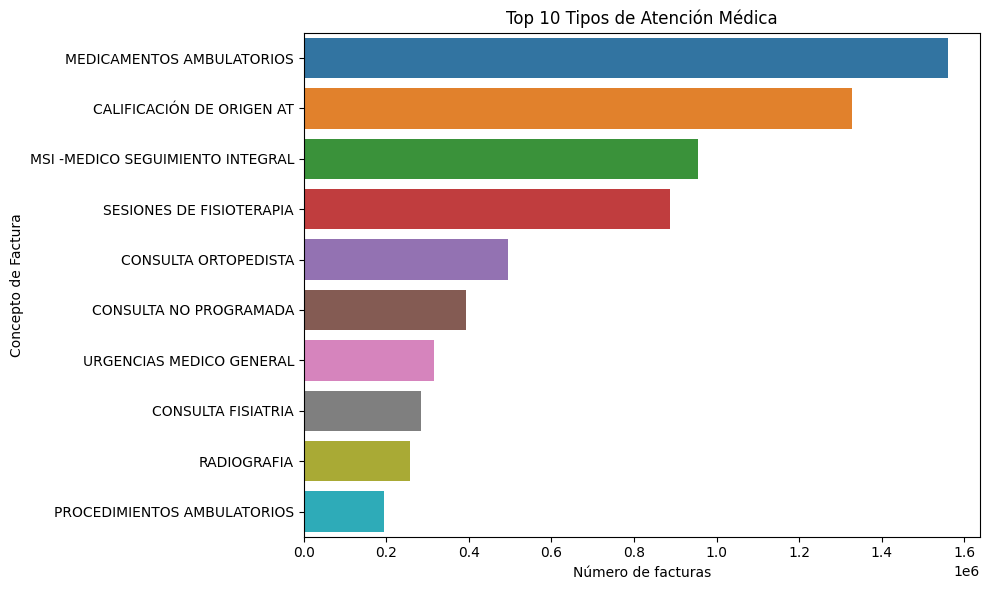

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identifica las 10 etiquetas más comunes
top10 = df_salud["Concepto_Factura_Desc"].value_counts().nlargest(10).index

# Filtra el DataFrame para quedarte sólo con esas 10
df_top10 = df_salud[df_salud["Concepto_Factura_Desc"].isin(top10)]

# Grafica de barras
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df_top10,
    y="Concepto_Factura_Desc",
    order=top10
)
plt.title("Top 10 Tipos de Atención Médica")
plt.xlabel("Número de facturas")
plt.ylabel("Concepto de Factura")
plt.tight_layout()
plt.show()

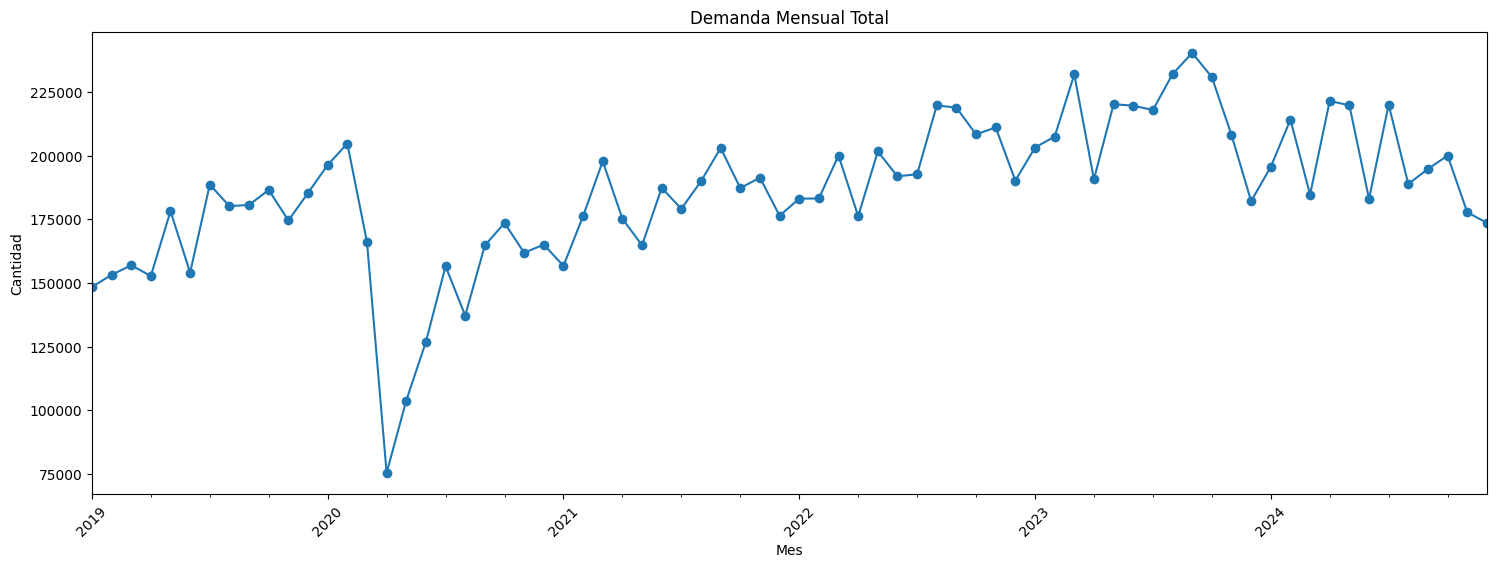

In [12]:
# Asegurarse de que FECHA_ATENCION es datetime
df_salud['Mes'] = df_salud['FECHA_ATENCION'].dt.to_period('M')

# Agrupar la demanda (Cantidad) por mes
demanda_por_mes = df_salud.groupby('Mes')['Cantidad'].sum().sort_index()

plt.figure(figsize=(18,6))
demanda_por_mes.plot(marker='o')
plt.title("Demanda Mensual Total")
plt.xlabel("Mes")
plt.ylabel("Cantidad")
plt.xticks(rotation=45)
plt.show()

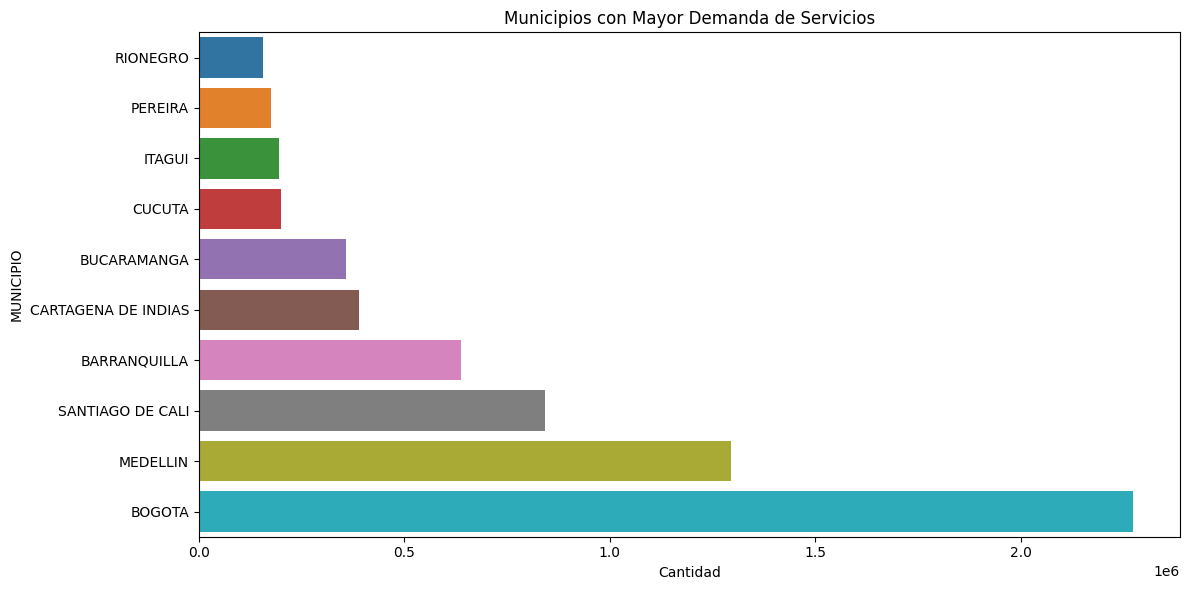

In [13]:
# Agrupar y sumar las cantidades por municipio
demanda_municipio = (
    df_salud
    .groupby("MUNICIPIO", observed=True)["Cantidad"]
    .sum()
    .reset_index()
)

# Obtener los 10 municipios con mayor demanda
top10 = demanda_municipio.nlargest(10, "Cantidad")

# Ordenar los valores para el gráfico (opcional, dependiendo de la preferencia)
top10 = top10.sort_values("Cantidad", ascending=True)

# Crear el gráfico
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top10,
    x="Cantidad",
    y="MUNICIPIO",
    order=top10["MUNICIPIO"]  # Asegura el orden correcto
)
plt.title("Municipios con Mayor Demanda de Servicios")
plt.tight_layout()  # Mejora el espacio del gráfico
plt.show()

**Tendencias por tipo de servicio médico**

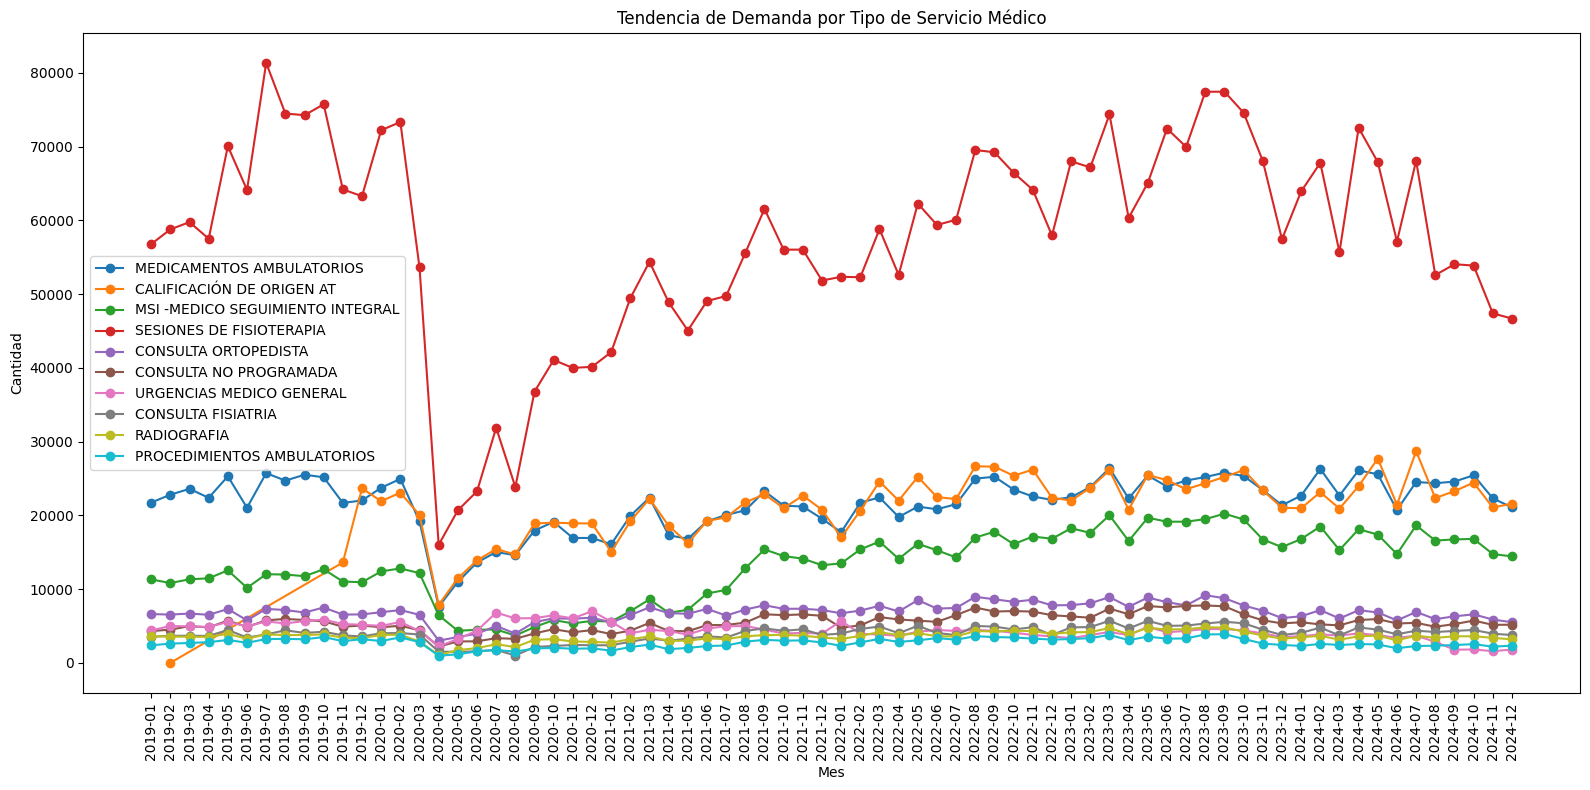

In [14]:
# Asegurarse de que FECHA_ATENCION es datetime
df_salud['Mes'] = df_salud['FECHA_ATENCION'].dt.to_period('M')

# Agrupar por mes y tipo de atención
tendencia_por_tipo = df_salud.groupby(['Mes', 'Concepto_Factura_Desc'])['Cantidad'].sum().reset_index()

# Obtener los 10 tipos de atención más comunes para simplificar la visualización
top_tipos = df_salud['Concepto_Factura_Desc'].value_counts().nlargest(10).index

# Filtrar solo los tipos top
tendencia_por_tipo_top = tendencia_por_tipo[tendencia_por_tipo['Concepto_Factura_Desc'].isin(top_tipos)]

# Convertir Mes a string para mejor visualización
tendencia_por_tipo_top['Mes'] = tendencia_por_tipo_top['Mes'].astype(str)

# Crear gráfico de líneas
plt.figure(figsize=(16, 8))
for tipo in top_tipos:
    data = tendencia_por_tipo_top[tendencia_por_tipo_top['Concepto_Factura_Desc'] == tipo]
    plt.plot(data['Mes'], data['Cantidad'], marker='o', label=tipo)

plt.title('Tendencia de Demanda por Tipo de Servicio Médico')
plt.xlabel('Mes')
plt.ylabel('Cantidad')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Análisis específico por municipio**

Estadísticas por municipio:


,Municipio,Total_Demanda,Num_Atenciones,Tipos_Servicio,Demanda_Promedio
98,BOGOTA,2273325.0,1791116,359,1.269223
506,MEDELLIN,1294713.0,1139419,345,1.136292
819,SANTIAGO DE CALI,842845.0,624421,335,1.349802
81,BARRANQUILLA,638509.0,463585,318,1.377329
151,CARTAGENA DE INDIAS,388890.0,272005,294,1.429716
...,...,...,...,...,...
888,TARAPACA,3.0,3,1,1.000000
137,CAMPOHERMOSO,3.0,3,1,1.000000
647,PUERTO ALEGRIA,2.0,2,2,1.000000
23,ALMEIDA,2.0,2,1,1.000000


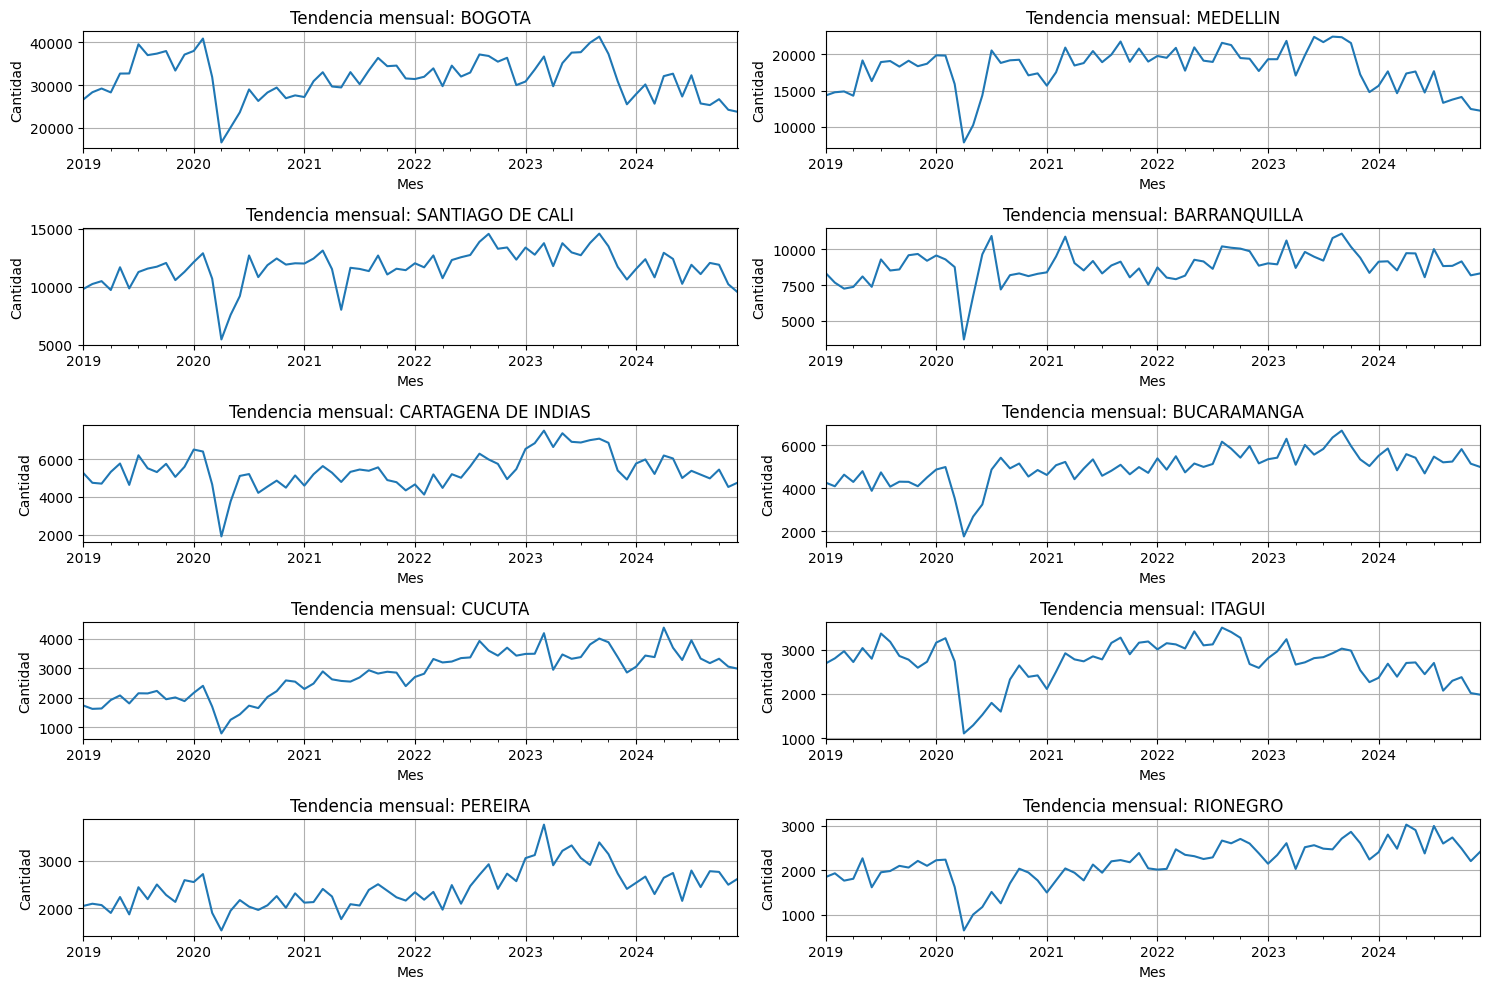

In [15]:
# Agrupar datos por municipio
datos_por_municipio = df_salud.groupby('MUNICIPIO').agg({
    'Cantidad': 'sum',
    'FECHA_ATENCION': 'count',
    'Concepto_Factura_Desc': lambda x: x.nunique(),
}).reset_index()

# Renombrar columnas
datos_por_municipio.columns = ['Municipio', 'Total_Demanda', 'Num_Atenciones', 'Tipos_Servicio']

# Calcular promedio de demanda por atención
datos_por_municipio['Demanda_Promedio'] = datos_por_municipio['Total_Demanda'] / datos_por_municipio['Num_Atenciones']

# Visualizar estadísticas por municipio (todos los municipios)
print("Estadísticas por municipio:")
display(datos_por_municipio.sort_values('Total_Demanda', ascending=False))

# Analizar más a fondo los 10 municipios principales
top10_municipios = datos_por_municipio.nlargest(10, 'Total_Demanda')['Municipio'].tolist()

# Para cada municipio top, analizar la tendencia mensual
plt.figure(figsize=(15, 10))

for i, municipio in enumerate(top10_municipios):
    # Filtrar datos del municipio
    df_muni = df_salud[df_salud['MUNICIPIO'] == municipio]
    
    # Agrupar por mes
    df_muni_mes = df_muni.groupby(df_muni['FECHA_ATENCION'].dt.to_period('M'))['Cantidad'].sum()
    
    # Crear subgráfico
    plt.subplot(5, 2, i+1)
    df_muni_mes.plot()
    plt.title(f'Tendencia mensual: {municipio}')
    plt.xlabel('Mes')
    plt.ylabel('Cantidad')
    plt.grid(True)

plt.tight_layout()
plt.show()

**Patrones estacionales**

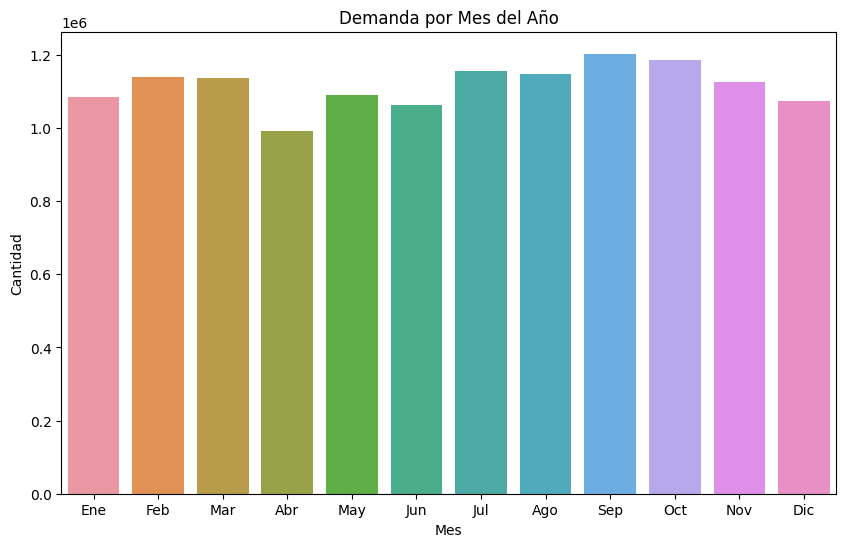

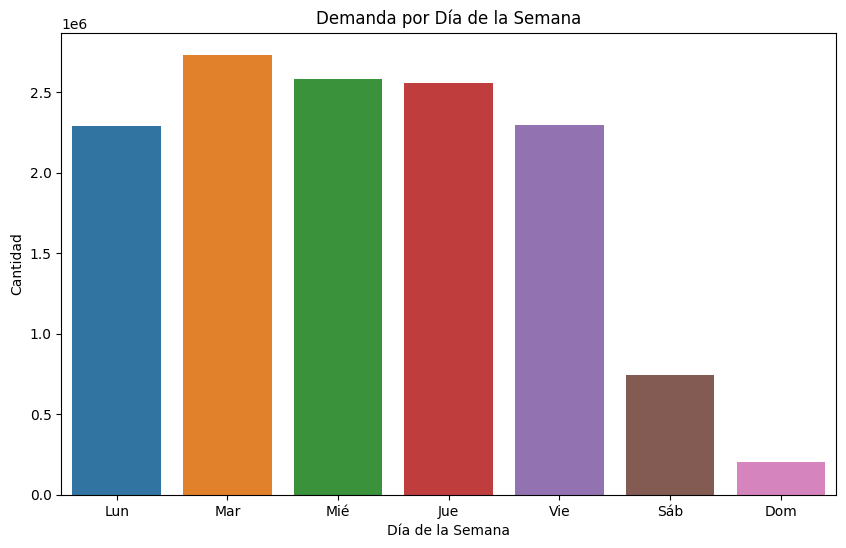

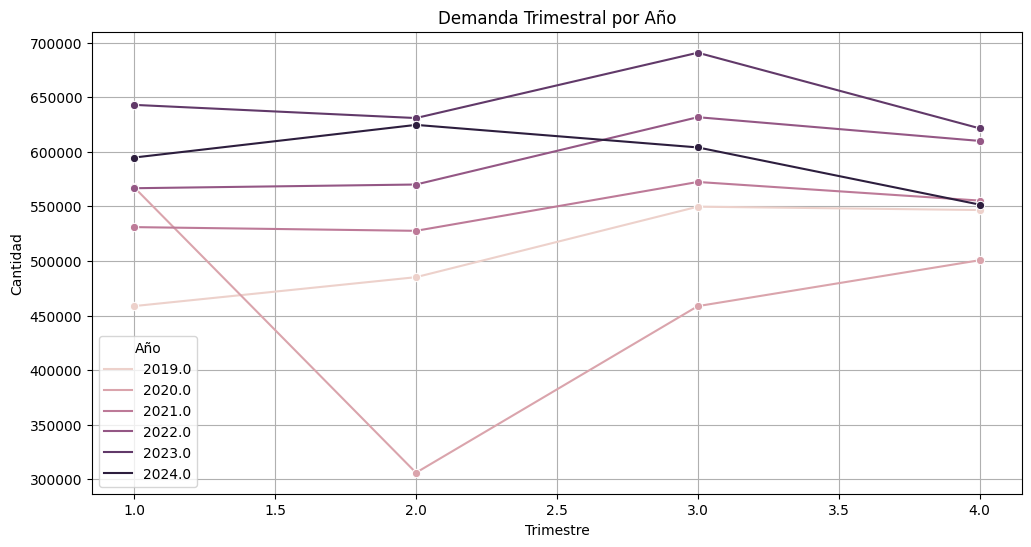

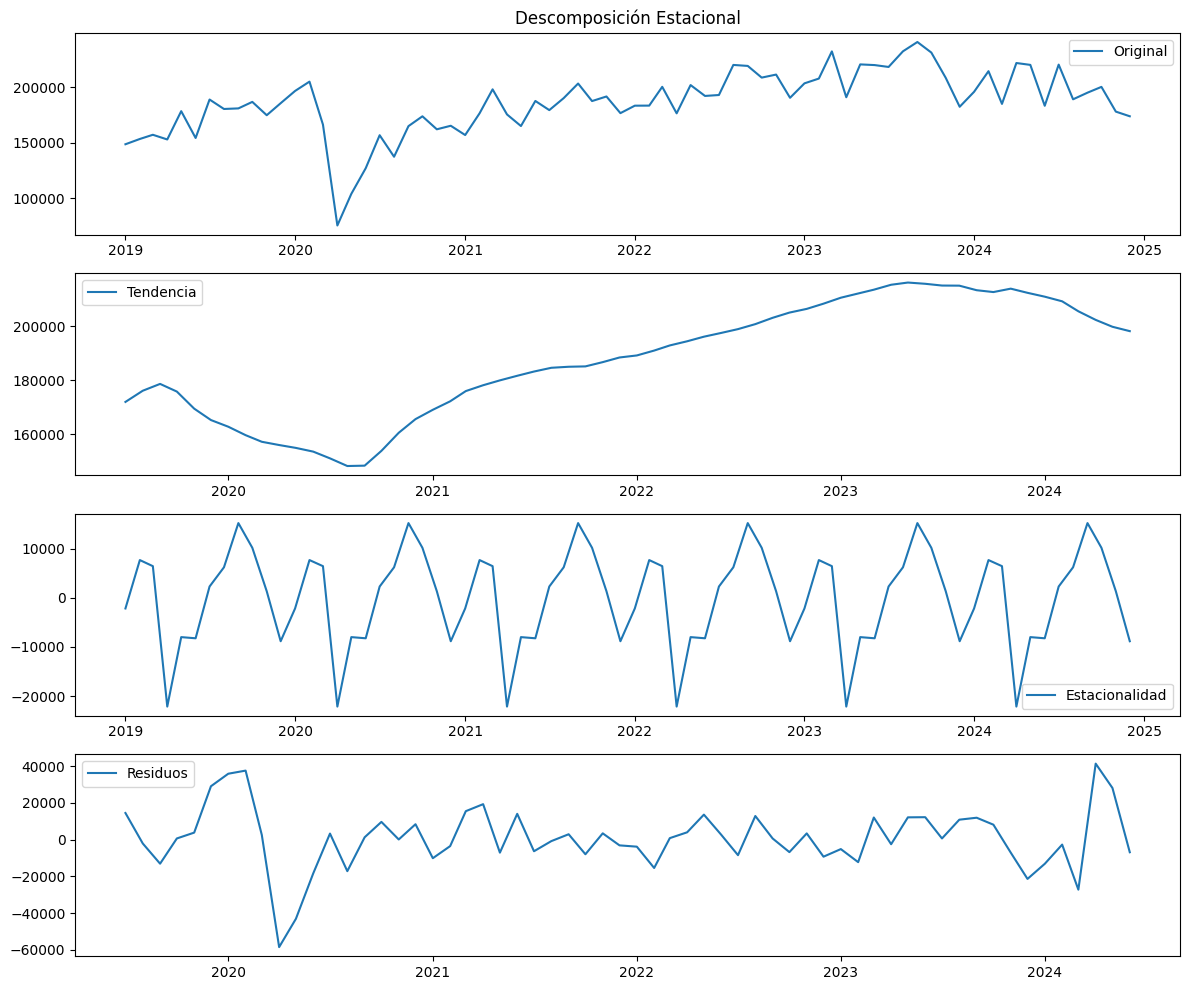

In [16]:
# Crear variables para diferentes medidas temporales
df_salud['Año'] = df_salud['FECHA_ATENCION'].dt.year
df_salud['Mes'] = df_salud['FECHA_ATENCION'].dt.month
df_salud['DiaSemana'] = df_salud['FECHA_ATENCION'].dt.dayofweek  # 0=Lunes, 6=Domingo
df_salud['DiaMes'] = df_salud['FECHA_ATENCION'].dt.day
df_salud['Trimestre'] = df_salud['FECHA_ATENCION'].dt.quarter

# 1. Análisis por mes del año
demanda_por_mes = df_salud.groupby('Mes')['Cantidad'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Mes', y='Cantidad', data=demanda_por_mes)
plt.title('Demanda por Mes del Año')
plt.xlabel('Mes')
plt.ylabel('Cantidad')
plt.xticks(range(12), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
plt.show()

# Análisis por día de la semana
demanda_por_dia = df_salud.groupby('DiaSemana')['Cantidad'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='DiaSemana', y='Cantidad', data=demanda_por_dia)
plt.title('Demanda por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Cantidad')
plt.xticks(range(7), ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom'])
plt.show()

# Análisis por trimestre
demanda_por_trimestre = df_salud.groupby(['Año', 'Trimestre'])['Cantidad'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='Trimestre', y='Cantidad', hue='Año', data=demanda_por_trimestre, marker='o')
plt.title('Demanda Trimestral por Año')
plt.xlabel('Trimestre')
plt.ylabel('Cantidad')
plt.grid(True)
plt.show()


# Análisis de estacionalidad 
from statsmodels.tsa.seasonal import seasonal_decompose

# Preparar serie temporal para decomposición
ts_data = df_salud.groupby(df_salud['FECHA_ATENCION'].dt.to_period('M'))['Cantidad'].sum()
ts_data.index = pd.to_datetime(ts_data.index.astype(str))

# Realizar descomposición estacional (si hay suficientes datos)
if len(ts_data) >= 24:  # Necesitamos al menos 2 años de datos
    decomposition = seasonal_decompose(ts_data, model='additive', period=12)
    
    # Graficar la descomposición
    plt.figure(figsize=(12, 10))
    plt.subplot(411)
    plt.plot(ts_data, label='Original')
    plt.legend(loc='best')
    plt.title('Descomposición Estacional')
    
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Tendencia')
    plt.legend(loc='best')
    
    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Estacionalidad')
    plt.legend(loc='best')
    
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residuos')
    plt.legend(loc='best')
    
    plt.tight_layout()
    plt.show()

**Detección de valores atípicos, datos faltantes y errores**

Total de valores faltantes por columna:
FECHA_ATENCION           2
Concepto_Factura_Desc    1
Cantidad                 0
MUNICIPIO                0
Mes                      2
Año                      2
DiaSemana                2
DiaMes                   2
Trimestre                2
dtype: int64


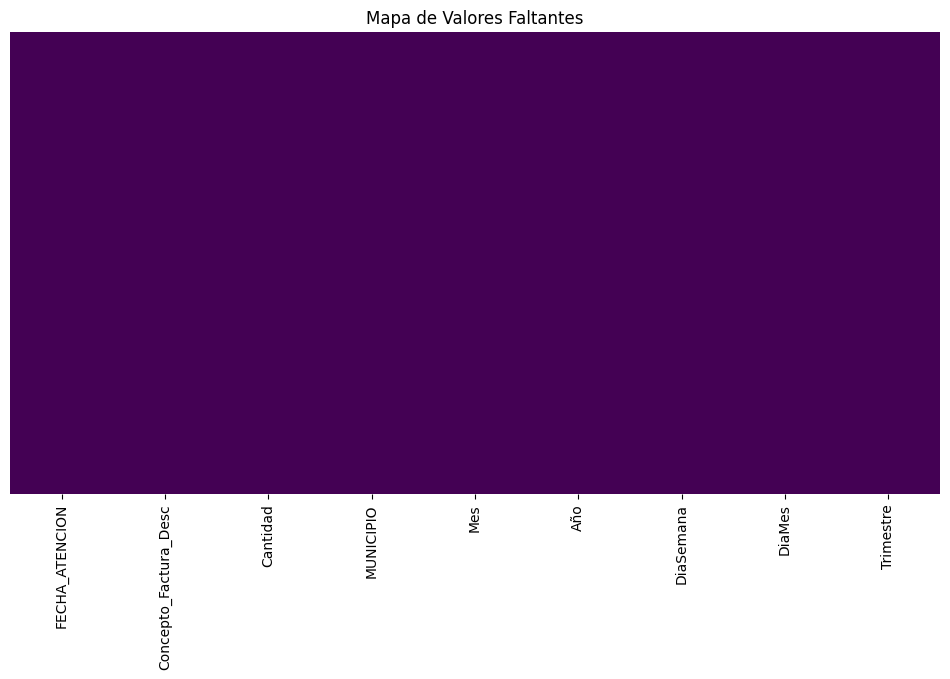

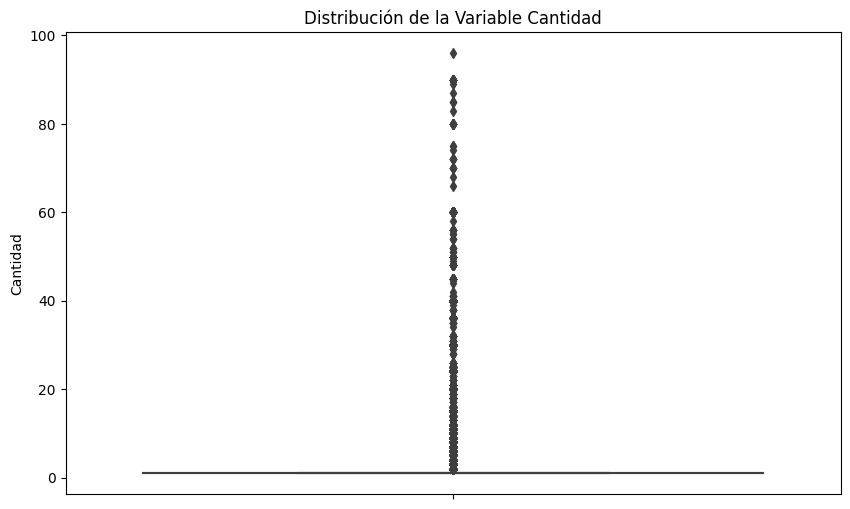

Valores atípicos - Límite inferior: 1.0, Límite superior: 1.0
Número de outliers: 888697
Registros con cantidad negativa: 0
Registros con cantidad cero: 0
Rango de fechas: 2019-01-01 00:00:00 a 2024-12-31 22:35:00
Registros con fechas futuras: 0
Número de registros duplicados: 874
Columna Concepto_Factura_Desc: 422 valores únicos
  ⚠️ Esta columna tiene muchos valores únicos, posible inconsistencia en nomenclatura
  Valores más comunes:
Concepto_Factura_Desc
MEDICAMENTOS AMBULATORIOS           1560329
CALIFICACIÓN DE ORIGEN AT           1328341
MSI -MEDICO SEGUIMIENTO INTEGRAL     955993
SESIONES DE FISIOTERAPIA             886346
CONSULTA ORTOPEDISTA                 495017
Name: count, dtype: int64
  Valores menos comunes:
Concepto_Factura_Desc
CAMA DE ACOMPAÑANTE CON ALIMENTACIÓN        1
SEG  ADAPTACIÓN RECONVERSION MANO OBRA(L    1
APELACIÓN JUNTA NACIONAL PCL                1
SUERO ANTIOFIDICO, SERPIENTES (L)           1
SEGUIMIENTO GIPAC (ALTA COMPLEJIDAD) (L)    1
Name: count, d

In [17]:
# Análisis de valores faltantes
print("Total de valores faltantes por columna:")
print(df_salud.isnull().sum())

# Visualización de valores faltantes
plt.figure(figsize=(12, 6))
sns.heatmap(df_salud.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Mapa de Valores Faltantes')
plt.show()

# Detección de valores atípicos en la variable "Cantidad"
plt.figure(figsize=(10, 6))
sns.boxplot(y=df_salud['Cantidad'])
plt.title('Distribución de la Variable Cantidad')
plt.ylabel('Cantidad')
plt.show()

# Cálculo de percentiles para identificar outliers
Q1 = df_salud['Cantidad'].quantile(0.25)
Q3 = df_salud['Cantidad'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Valores atípicos - Límite inferior: {lower_bound}, Límite superior: {upper_bound}")
print(f"Número de outliers: {df_salud[(df_salud['Cantidad'] < lower_bound) | (df_salud['Cantidad'] > upper_bound)].shape[0]}")

# Análisis de valores inconsistentes
# Verificar si hay cantidades negativas o cero (que podrían ser erróneas)
print(f"Registros con cantidad negativa: {df_salud[df_salud['Cantidad'] < 0].shape[0]}")
print(f"Registros con cantidad cero: {df_salud[df_salud['Cantidad'] == 0].shape[0]}")

# Verificación de fechas
min_date = df_salud['FECHA_ATENCION'].min()
max_date = df_salud['FECHA_ATENCION'].max()
print(f"Rango de fechas: {min_date} a {max_date}")

# Comprobar si hay fechas futuras (posteriores a la fecha actual)
future_dates = df_salud[df_salud['FECHA_ATENCION'] > pd.Timestamp.now()]
print(f"Registros con fechas futuras: {future_dates.shape[0]}")

# Verificar duplicados exactos
duplicados = df_salud.duplicated()
print(f"Número de registros duplicados: {duplicados.sum()}")

# Comprobar problemas potenciales en los valores categóricos
for col in ['Concepto_Factura_Desc', 'MUNICIPIO']:
    n_values = df_salud[col].nunique()
    print(f"Columna {col}: {n_values} valores únicos")
    
    # Si hay muchos valores únicos, puede haber inconsistencias
    if n_values > 100:  # Umbral arbitrario
        print("  ⚠️ Esta columna tiene muchos valores únicos, posible inconsistencia en nomenclatura")
        
        # Mostrar los valores más y menos frecuentes
        print("  Valores más comunes:")
        print(df_salud[col].value_counts().head())
        print("  Valores menos comunes:")
        print(df_salud[col].value_counts().tail())

# Análisis de la capacidad máxima del prestador vs. demanda real
if 'Geogra_Municipio_Id' in df_salud.columns and 'Geogra_Municipio_Id' in df_prestadores.columns:
    # Agrupar demanda por municipio
    demanda_municipio = df_salud.groupby('Geogra_Municipio_Id')['Cantidad'].sum().reset_index()
    
    # Combinar con información de capacidad
    analisis_capacidad = demanda_municipio.merge(df_prestadores, on='Geogra_Municipio_Id', how='inner')
    analisis_capacidad['Porcentaje_Uso'] = (analisis_capacidad['Cantidad'] / analisis_capacidad['max_cantidad']) * 100
    
    # Identificar posibles problemas
    print("Municipios con posible sobrecarga (uso > 90%):")
    display(analisis_capacidad[analisis_capacidad['Porcentaje_Uso'] > 90])
    
    print("Municipios con baja utilización (uso < 20%):")
    display(analisis_capacidad[analisis_capacidad['Porcentaje_Uso'] < 20])

**Análisis de series temporales específico**

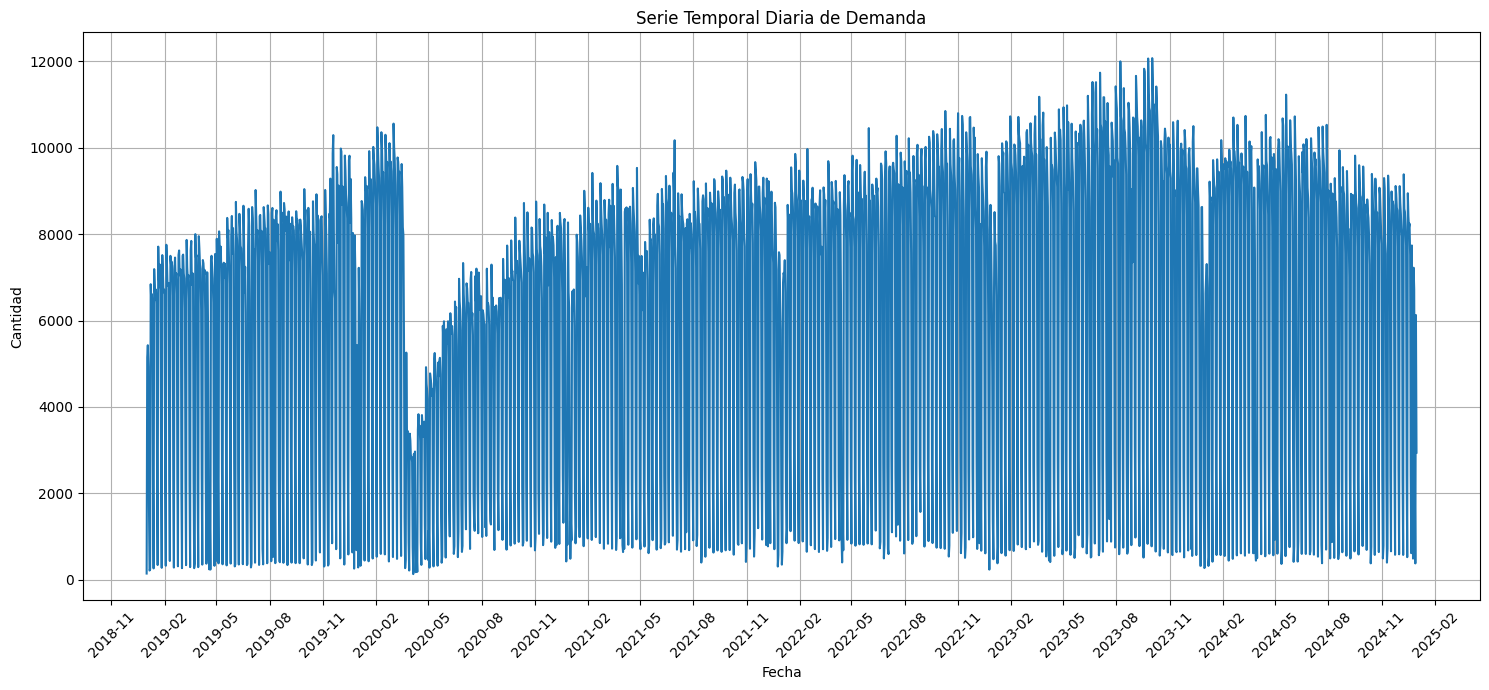

Prueba de Dickey-Fuller Aumentada:
Estadística de prueba: -4.687377682611372
Valor p: 8.886933192771641e-05
Valores críticos: {'1%': -3.4333684674663467, '5%': -2.8628734534635902, '10%': -2.5674798640234444}
La serie es estacionaria (rechazamos H0)


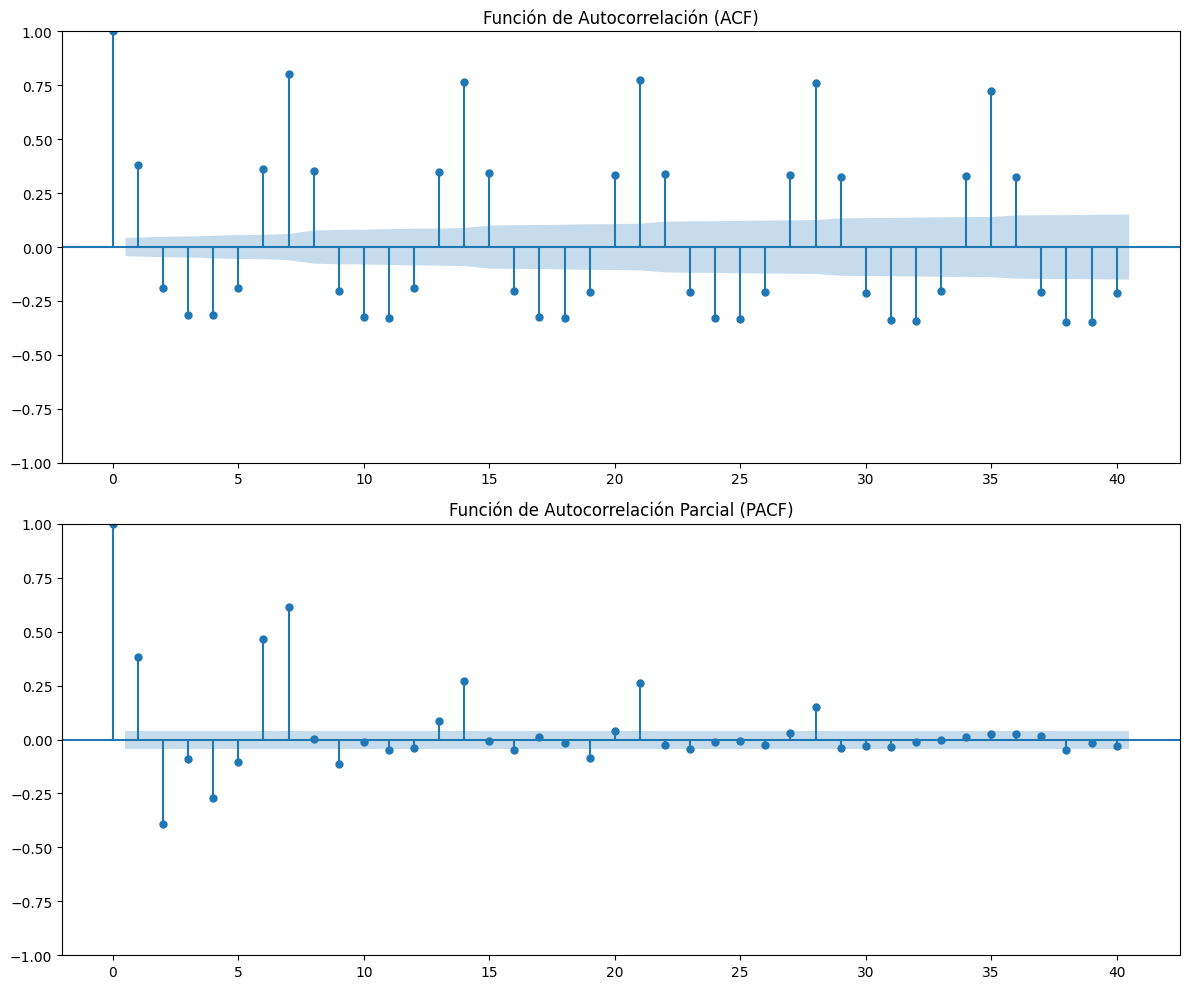

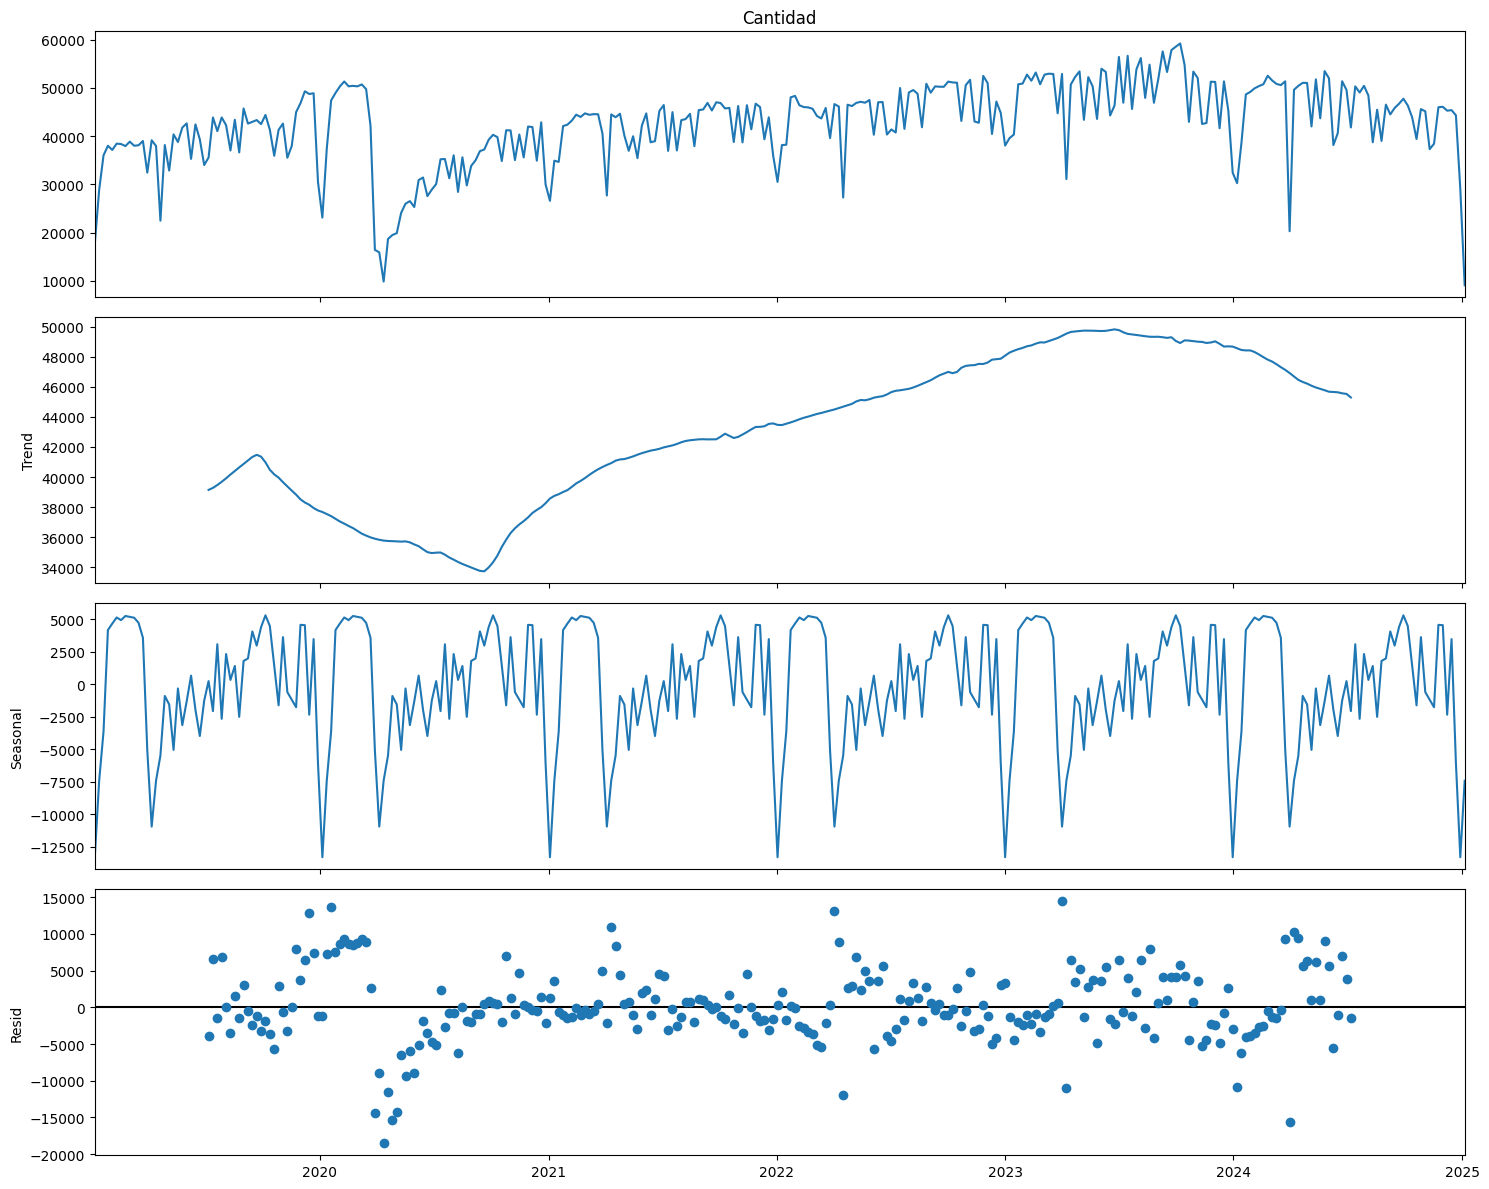

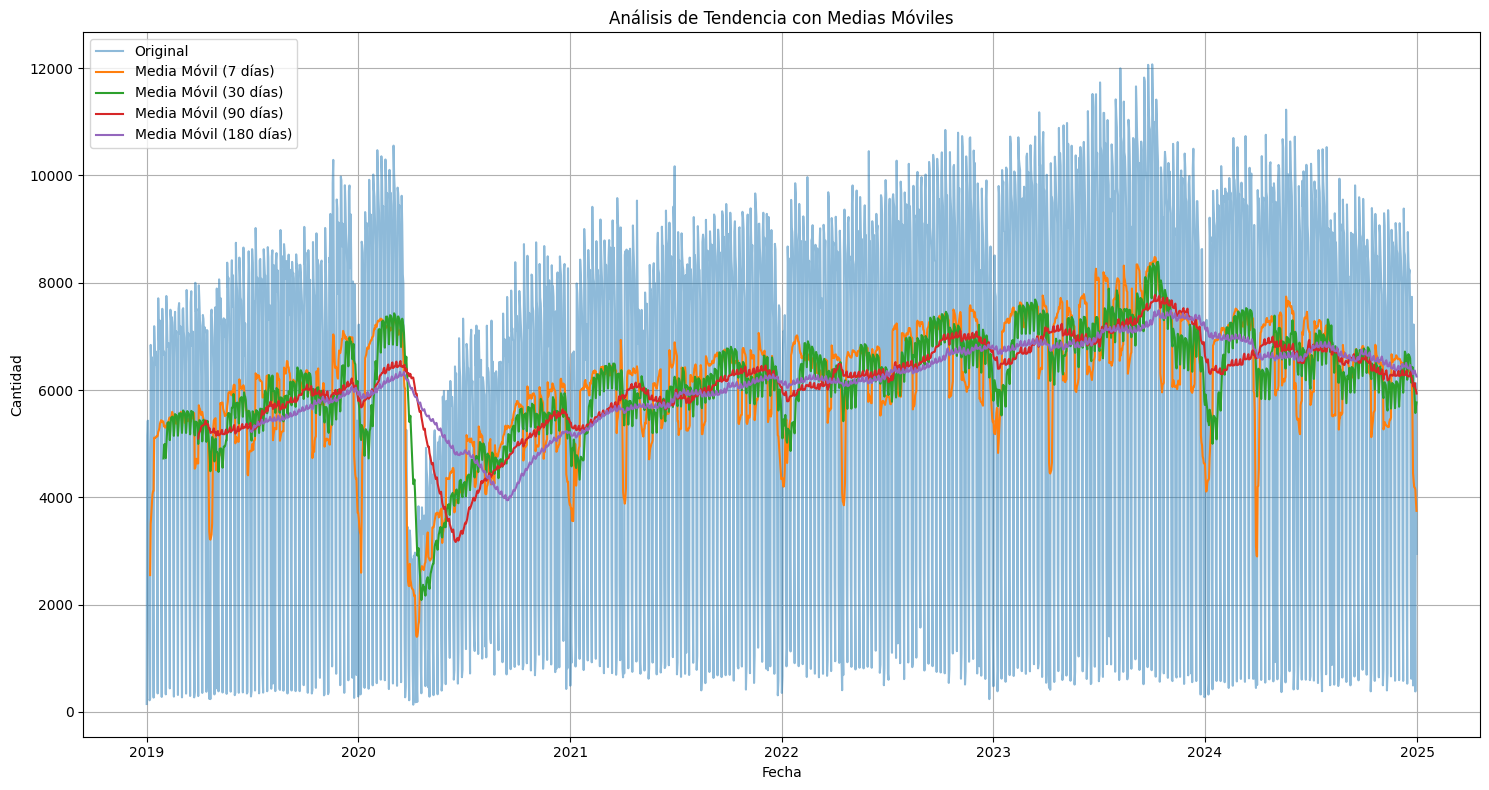

In [18]:
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller, acf, pacf
import statsmodels.api as sm

# Preparar serie temporal diaria
ts_diaria = df_salud.groupby(df_salud['FECHA_ATENCION'].dt.date)['Cantidad'].sum()
ts_diaria.index = pd.to_datetime(ts_diaria.index)

# Visualizar la serie temporal completa
plt.figure(figsize=(15, 7))
plt.plot(ts_diaria)
plt.title('Serie Temporal Diaria de Demanda')
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analizar la estacionariedad de la serie
result = adfuller(ts_diaria.dropna())
print('Prueba de Dickey-Fuller Aumentada:')
print(f'Estadística de prueba: {result[0]}')
print(f'Valor p: {result[1]}')
print(f'Valores críticos: {result[4]}')
if result[1] <= 0.05:
    print("La serie es estacionaria (rechazamos H0)")
else:
    print("La serie no es estacionaria (no rechazamos H0)")

# Analizar autocorrelación
plt.figure(figsize=(12, 10))

# ACF
plt.subplot(211)
sm.graphics.tsa.plot_acf(ts_diaria.dropna(), lags=40, ax=plt.gca())
plt.title('Función de Autocorrelación (ACF)')

# PACF
plt.subplot(212)
sm.graphics.tsa.plot_pacf(ts_diaria.dropna(), lags=40, ax=plt.gca())
plt.title('Función de Autocorrelación Parcial (PACF)')

plt.tight_layout()
plt.show()

# Descomposición de la serie temporal (tendencia, estacionalidad, residuos)
# Usar la serie semanal para reducir el ruido
ts_semanal = df_salud.groupby(pd.Grouper(key='FECHA_ATENCION', freq='W'))['Cantidad'].sum()

# Realizar descomposición
descomposicion = sm.tsa.seasonal_decompose(ts_semanal, model='additive', period=52)

# Graficar
fig = descomposicion.plot()
fig.set_size_inches(15, 12)
plt.tight_layout()
plt.show()

# Análisis de venta móvil para detectar tendencias a largo plazo
ventanas = [7, 30, 90, 180]
plt.figure(figsize=(15, 8))

plt.plot(ts_diaria, alpha=0.5, label='Original')

for ventana in ventanas:
    ts_ma = ts_diaria.rolling(window=ventana).mean()
    plt.plot(ts_ma, label=f'Media Móvil ({ventana} días)')

plt.title('Análisis de Tendencia con Medias Móviles')
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **PIPELINE**

**Configuracion**

In [19]:
# ------------------------- Configuración -------------------------------
GPUS = tf.config.list_physical_devices('GPU')
if GPUS:
    for g in GPUS:
        tf.config.experimental.set_memory_growth(g, True)
    print(f"GPUs detectadas: {len(GPUS)}")
else:
    print("Usando CPU")

XGB_PARAMS = {'tree_method':'gpu_hist','predictor':'gpu_predictor','verbosity':0}
WINDOW = 30
TOP_N = 5
TOP_M = 1
CV_SPLITS = 5
HORIZON = 365  # días a predecir

GPUs detectadas: 2


In [20]:
# ------------------------- Métricas extendidas ---------------------------
def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    mask = denom != 0
    return 100 * np.mean(np.abs(y_true[mask] - y_pred[mask]) / denom[mask])

def mase(y_true, y_pred, y_insample, season=1):
    mae_model = mean_absolute_error(y_true, y_pred)
    diff = np.abs(y_insample[season:] - y_insample[:-season])
    mae_naive = diff.mean()
    return mae_model / mae_naive if mae_naive != 0 else np.nan

**Preparacion De Datos**

In [21]:
# Exógenas
def make_exog(idx):
    cal = holidays.Colombia()
    df_ex = pd.DataFrame(index=idx)
    df_ex['is_weekend'] = (idx.dayofweek >= 5).astype(int)
    df_ex['is_holiday'] = idx.to_series().apply(lambda d: 1 if d in cal else 0)
    df_ex['covid'] = idx.to_series().apply(lambda d: 1 if (d.year==2020 and d.month>=3) or d.year==2021 else 0)
    return df_ex

# Serie diaria univariante
def get_ts(df, muni, serv):
    ts = df[(df['MUNICIPIO']==muni)&(df['Concepto_Factura_Desc']==serv)]
    ts = ts.set_index('FECHA_ATENCION')['Cantidad']
    ts = ts.resample('D').sum().asfreq('D').fillna(0)
    return ts
    
'''
# Features: lags + exógenas
def make_hybrid_features(ts):
    ex = make_exog(ts.index)
    df_feat = ex.copy(); df_feat['y'] = ts
    for L in [7, 30]: df_feat[f'lag_{L}'] = df_feat['y'].shift(L)
    df_feat['roll7'] = df_feat['y'].rolling(7).mean().shift(1)
    df_feat.dropna(inplace=True)
    return df_feat.drop('y',axis=1), df_feat['y']
'''

# Implementación híbrida de características basadas en ventanas
def make_hybrid_features(ts):
    # Variables exógenas (mantener como está)
    ex = make_exog(ts.index)
    df_feat = ex.copy(); df_feat['y'] = ts
    
    # Características de ventana móvil (corto plazo)
    for L in [7, 30]: 
        df_feat[f'lag_{L}'] = df_feat['y'].shift(L)
    df_feat['roll7'] = df_feat['y'].rolling(7).mean().shift(1)
    df_feat['roll30'] = df_feat['y'].rolling(30).mean().shift(1)
    
    # Características de ventana expandible (largo plazo)
    df_feat['expanding_mean'] = df_feat['y'].expanding().mean().shift(1)
    df_feat['expanding_std'] = df_feat['y'].expanding().std().shift(1)
    
    # Características estacionales (considerar mismo periodo del año anterior)
    df_feat['season_365'] = df_feat['y'].shift(365)  # Mismo día del año anterior
    
    # Tendencia (diferencia entre medias móviles de diferente periodo)
    df_feat['trend'] = df_feat['roll30'] - df_feat['expanding_mean']
    
    df_feat.dropna(inplace=True)
    return df_feat.drop('y', axis=1), df_feat['y']

# Secuencias para DL
def make_seq(vals, w):
    X, y = [], []
    for i in range(len(vals) - w): X.append(vals[i:i+w]); y.append(vals[i+w])
    return np.array(X), np.array(y)

In [22]:
# ------------------------- Train/Evaluate CV -------------------------------
def train_evaluate(ts, model_type, params):
    tscv = TimeSeriesSplit(n_splits=CV_SPLITS)
    scores = []
    y_insample = ts.values
    for tr, te in tscv.split(ts):
        t_tr, t_te = ts.iloc[tr], ts.iloc[te]
        if len(t_tr) < WINDOW + 1 or len(t_te) == 0: continue
        # Combined
        if model_type == 'Combined':
            ar = ARIMA(t_tr, order=(1,1,1)).fit()
            resid = (t_tr - ar.fittedvalues).dropna()
            Xr, yr = make_hybrid_features(resid)
            xbm = xgb.XGBRegressor(**params).fit(Xr, yr)
            fc_ar = ar.forecast(steps=len(t_te))
            hist = pd.concat([resid, pd.Series(fc_ar, index=t_te.index)])
            Xf, _ = make_hybrid_features(hist)
            Xf = Xf.loc[t_te.index]
            fc_xgb = xbm.predict(Xf)
            y_pred = fc_ar.values + fc_xgb; y_true = t_te.values
        # LSTM
        elif model_type == 'LSTM':
            Xtr, Ytr = make_seq(t_tr.values, WINDOW)
            Xte, _ = make_seq(np.concatenate([t_tr.values[-WINDOW:], t_te.values]), WINDOW)
            model = models.Sequential([
                layers.Input((WINDOW,1)), layers.LSTM(params['units']), layers.Dropout(0.2), layers.Dense(1)
            ])
            model.compile('adam','mse')
            es = callbacks.EarlyStopping(patience=3, restore_best_weights=True)
            model.fit(Xtr.reshape(-1,WINDOW,1), Ytr,
                      epochs=params['epochs'], batch_size=32, validation_split=0.1,
                      verbose=0, callbacks=[es])
            y_pred = model.predict(Xte.reshape(-1,WINDOW,1), verbose=0).flatten()[-len(t_te):]; y_true = t_te.values
        # NBeats
        else:
            Xtr, Ytr = make_seq(t_tr.values, WINDOW)
            Xte, _ = make_seq(np.concatenate([t_tr.values[-WINDOW:], t_te.values]), WINDOW)
            class Block(layers.Layer):
                def __init__(self):
                    super().__init__()
                    self.hidden = [layers.Dense(params['units'], activation='relu') for _ in range(4)]
                    self.backcast = layers.Dense(WINDOW)
                    self.forecast = layers.Dense(1)
                def call(self, x):
                    h = x
                    for lyr in self.hidden: h = lyr(h)
                    return self.backcast(h), self.forecast(h)
            inp = layers.Input(shape=(WINDOW,)); res = inp; fc = 0
            for _ in range(params['stacks']): b, f = Block()(res); res -= b; fc += f
            nb = models.Model(inp, fc); nb.compile('adam','mse')
            es = callbacks.EarlyStopping(patience=3, restore_best_weights=True)
            nb.fit(Xtr, Ytr, epochs=params['epochs'], batch_size=32, validation_split=0.1,
                   verbose=0, callbacks=[es])
            y_pred = nb.predict(Xte, verbose=0).flatten()[-len(t_te):]; y_true = t_te.values
        # Métricas
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        mae  = mean_absolute_error(y_true, y_pred)
        sm   = smape(y_true, y_pred)
        mz   = mase(y_true, y_pred, y_insample)
        scores.append({'RMSE':rmse,'MAE':mae,'SMAPE':sm,'MASE':mz})
    return pd.DataFrame(scores).mean() if scores else pd.Series({'RMSE':np.nan,'MAE':np.nan,'SMAPE':np.nan,'MASE':np.nan})

# Nested CV tuning NBeats
def nested_cv(ts, grid):
    outer = TimeSeriesSplit(n_splits=3)
    best_p, best_s = None, np.inf
    for tr, _ in outer.split(ts):
        t_tr = ts.iloc[tr]
        for p in ParameterGrid(grid):
            r = train_evaluate(t_tr, 'NBeats', p)['RMSE']
            if r < best_s: best_s, best_p = r, p
    return best_p, best_s

In [23]:
# ------------------------- Visualización -------------------------------
def plot_model_metrics(summary):
    df = pd.DataFrame(summary).set_index('model')
    df[['RMSE','MAE','SMAPE','MASE']].plot(kind='bar')
    plt.title('Comparación de métricas por modelo')
    plt.tight_layout()
    plt.show()

# Retrain completo y forecast iterativo para un modelo
def retrain_and_forecast(ts, model_type, params, horizon=HORIZON):
    dates = pd.date_range(ts.index[-1] + pd.Timedelta(days=1), periods=horizon, freq='D')
    # Combined
    if model_type == 'Combined':
        ar = ARIMA(ts, order=(1,1,1)).fit()
        resid = (ts - ar.fittedvalues).dropna()
        Xr, yr = make_hybrid_features(resid)
        xbm = xgb.XGBRegressor(**params).fit(Xr, yr)
        fc_ar = ar.forecast(steps=horizon)
        series_all = pd.concat([ts, pd.Series(fc_ar.values, index=dates)])
        Xf, _ = make_hybrid_features(series_all)
        Xf_future = Xf.loc[dates]
        fc_xgb = xbm.predict(Xf_future)
        return pd.Series(fc_ar.values + fc_xgb, index=dates)
    # LSTM
    if model_type == 'LSTM':
        X, Y = make_seq(ts.values, WINDOW)
        model = models.Sequential([
            layers.Input((WINDOW,1)), layers.LSTM(params['units']), layers.Dropout(0.2), layers.Dense(1)
        ])
        model.compile('adam','mse')
        es = callbacks.EarlyStopping(patience=3, restore_best_weights=True)
        model.fit(X.reshape(-1,WINDOW,1), Y, epochs=params['epochs'], batch_size=32,
                  validation_split=0.1, verbose=0, callbacks=[es])
        hist = ts.values.tolist(); preds = []
        for _ in range(horizon):
            x = np.array(hist[-WINDOW:]).reshape(1,WINDOW,1)
            y_pred = model.predict(x, verbose=0).flatten()[0]
            preds.append(y_pred); hist.append(y_pred)
        return pd.Series(preds, index=dates)
    # NBeats
    X, Y = make_seq(ts.values, WINDOW)
    class Block(layers.Layer):
        def __init__(self):
            super().__init__(); self.hidden=[layers.Dense(params['units'],activation='relu') for _ in range(4)];
            self.backcast=layers.Dense(WINDOW); self.forecast=layers.Dense(1)
        def call(self,x):
            h=x
            for lyr in self.hidden: h=lyr(h)
            return self.backcast(h), self.forecast(h)
    inp=layers.Input(shape=(WINDOW,)); res=inp; fc=0
    for _ in range(params['stacks']): b,f=Block()(res); res-=b; fc+=f
    nb = models.Model(inp, fc); nb.compile('adam','mse')
    es=callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    nb.fit(X, Y, epochs=params['epochs'], batch_size=32, validation_split=0.1,
           verbose=0, callbacks=[es])
    hist = ts.values.tolist(); preds = []
    for _ in range(horizon):
        x = np.array(hist[-WINDOW:]).reshape(1,WINDOW)
        y_pred = nb.predict(x, verbose=0).flatten()[0]
        preds.append(y_pred); hist.append(y_pred)
    return pd.Series(preds, index=dates)

In [26]:
# CELDA 4: Preparación de datos para modelos
# ======================================
# Identificar los principales municipios y servicios para analizar
top_munis = df.groupby('MUNICIPIO')['Cantidad'].sum().nlargest(TOP_N).index
combos = [(m, s) for m in top_munis for s in df[df['MUNICIPIO']==m]
          .groupby('Concepto_Factura_Desc')['Cantidad'].sum().nlargest(TOP_M).index]

print(f"Se procesarán {len(combos)} combinaciones municipio-servicio:")
for i, (m, s) in enumerate(combos[:5]):
    print(f"{i+1}. {m} - {s}")
print("..." if len(combos) > 5 else "")

# CELDA 5: Evaluación de modelos
# ======================================
# Lista para almacenar resultados
summary = []

# Prueba el modelo combinado ARIMA+XGBoost
print("Evaluando modelo Combined (ARIMA+XGBoost)...")
metrics_combined = [train_evaluate(get_ts(df,m,s), 'Combined', XGB_PARAMS)
                   for m, s in combos[:5] if len(get_ts(df,m,s)) > WINDOW*2]
avg_combined = pd.DataFrame(metrics_combined).mean().to_dict()
avg_combined['model'] = 'Combined'
summary.append(avg_combined)
print("Completado.")

# Prueba el modelo LSTM
print("Evaluando modelo LSTM...")
metrics_lstm = [train_evaluate(get_ts(df,m,s), 'LSTM', {'epochs':10,'units':64})
               for m, s in combos[:5] if len(get_ts(df,m,s)) > WINDOW*2]
avg_lstm = pd.DataFrame(metrics_lstm).mean().to_dict()
avg_lstm['model'] = 'LSTM'
summary.append(avg_lstm)
print("Completado.")


# Optimiza hiperparámetros para NBeats (comentar si toma demasiado tiempo)
print("Optimizando hiperparámetros para NBeats...")
ts_first = get_ts(df, *combos[0])
best_p, best_s = nested_cv(ts_first, {'epochs':[10,20],'stacks':[2,3],'units':[128,256]})
print(f"Mejores parámetros para NBeats: {best_p}, Score: {best_s:.4f}")


# Prueba el modelo NBeats
print("Evaluando modelo NBeats...")
metrics_nbeats = [train_evaluate(get_ts(df,m,s), 'NBeats', best_p)
                 for m, s in combos[:5] if len(get_ts(df,m,s)) > WINDOW*2]
avg_nbeats = pd.DataFrame(metrics_nbeats).mean().to_dict()
avg_nbeats['model'] = 'NBeats'
summary.append(avg_nbeats)



# 3) Modelo NBeats (con parámetros por defecto)
print("Evaluando modelo NBeats (default parameters)...")
defaults_nbeats = {'epochs': 10, 'stacks': 2, 'units': 128}


# CELDA 6: Comparación de modelos
# ======================================
# Compara métricas de los modelos
plot_model_metrics(summary)

# Encuentra el mejor modelo basado en RMSE
best_model = min(summary, key=lambda x: x['RMSE'])['model']
print(f"Mejor modelo según RMSE: {best_model}")
if best_model == 'Combined':
    best_params = XGB_PARAMS
elif best_model == 'LSTM':
    best_params = {'epochs':10,'units':64}
else:
    best_params = defaults_nbeats

# CELDA 7: Pronóstico con el mejor modelo
# ======================================
# Realiza pronósticos para cada combinación municipio-servicio
print(f"Generando pronósticos con el modelo {best_model}...")

# Podemos limitar los pronósticos para no sobrecargar el notebook
for i, (muni, serv) in enumerate(combos[:3]):
    print(f"Pronóstico {i+1}/{min(3, len(combos))}: {muni} - {serv}")
    ts = get_ts(df, muni, serv)
    fc = retrain_and_forecast(ts, best_model, best_params, horizon=HORIZON)
    
    # Visualiza el pronóstico
    plt.figure(figsize=(15, 6))
    plt.plot(ts[-365:], label='Histórico')
    plt.plot(fc, label='Pronóstico')
    plt.title(f'Pronóstico {best_model} para {muni} - {serv}')
    plt.xlabel('Fecha')
    plt.ylabel('Cantidad')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Se procesarán 5 combinaciones municipio-servicio:
1. BOGOTA - SESIONES DE FISIOTERAPIA
2. MEDELLIN - SESIONES DE FISIOTERAPIA
3. SANTIAGO DE CALI - SESIONES DE FISIOTERAPIA
4. BARRANQUILLA - SESIONES DE FISIOTERAPIA
5. CARTAGENA DE INDIAS - SESIONES DE FISIOTERAPIA

Evaluando modelo Combined (ARIMA+XGBoost)...
Completado.
Evaluando modelo LSTM...
Completado.
Evaluando modelo NBeats (default parameters)...


NameError: name 'defaults_nbeats' is not defined

In [ ]:
# Encuentra el diccionario con el RMSE más bajo
best_entry = min(summary, key=lambda x: x['RMSE'])

# Desempaqueta modelo y RMSE
best_model = best_entry['model']
best_rmse = best_entry['RMSE']

print(f"Mejor modelo según RMSE: {best_model} (RMSE = {best_rmse:.4f})")